#### Cécile Della Valle - Novembre 2018

In [17]:
### IMPORTATION
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import math
import sys

In [18]:
### PLOTTING FUNCTION
def PlotDymamicSolution(xmax,ymax,vectorX,vectorY,nbData,evolution,vectorT):
    """ Function that allows to plot animate with a constant absisse vectorX (shape Nx1)
    and a solution evolving through time vectorY (shape NxnbData)."""

    # Set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(0, xmax), ylim=(0, ymax))
    line, = ax.plot([], [], lw=2)
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)


    # Initialization function: plot the background of each frame
    def Init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text

    # Animation function.  This is called sequentially
    def Animate1DT(i):
        x = vectorX
        y = vectorY[:,i]
        line.set_data(x, y)
        time_text.set_text(evolution%vectorT[i])
        return line, time_text

    anim = animation.FuncAnimation(fig, Animate1DT, \
    init_func=Init,\
    frames=nbData, interval=50, blit=True)
    
    
    # create the HTLM figure
    plt.close(anim._fig)
    HTML(anim.to_html5_video())

    # equivalent to rcParams['animation.html'] = 'html5'
    rc('animation', html='html5')

    return anim

# Equation de transport 1D

## Approche Théorique

Dans cet exemple, nous cherchons à estimer l'état d'un système composé de polymères de différentes tailles, c'est-à-dire composé de plusieurs polymères. Par hypothèse, la taille des polymères peut être décrite par une variable $x$. On autorise deux types de réactions pour ce système : les polymères peuvent soit polymériser en réagissant avec un monomère, soit dépolymériser en relachant un monomère. On étudie ce système sur un intervalle de temps $[0,T]$. Pour des polymères de tailles assez grandes (à partir de 100 monomères), ce système peut être correctement modélisé de manière continu en $x$ par le modèle de Lifschitz-Slyosov.  On note $y(x,t)$ la concentration de polymères de taille $x$ au temps $t$, $c(t)$ la concentration en monomère, $a(x)$ et $b(x)$ respectivement les vitesses de polymérisation et dépolymérisation des polymères de taille $x$:

$$
\begin{cases}
		\displaystyle \partial _t y(x,t) + \partial _x (a(x)c(t) -b(x))y(x,t) =0 & (x,t) \in (0,\ell) \times (0,T)  \\[0.1cm]
		\displaystyle \frac{\mathrm{d} c }{\mathrm{dt}} = \int _0 ^\infty y(x,t) (b(x)-a(x)c(t))\mathrm{dx}
	\end{cases}
$$

La difficulté de ce système réside principalement dans son caractère non-linéaire. C'est pourquoi, pour l'étudier, on se place donc d'abord dans le cas simple où la quantité de monomères est négligeable à l'origine de la réaction, à coefficient $b$ constant. On retrouve alors une équation de transport 1D :

$$
\begin{cases}
 \displaystyle \frac{\partial y}{\partial t}(x,t) - b \frac{\partial y} {\partial x}(x,t) = 0, & (x,t) \in (0,\ell) \times (0,T)  \\[0.1cm]
 y(x,0) = y_{0} (x)  \\
 y(L,t) = 0
\end{cases}
$$

On ajoute ainsi une condition de Dirichlet au bord du domaine en $x=L$, en effet nous avons supposé qu'il n'existait pas de polymère de taille supérieure à $L$. Dans ce cas particulier, on connait classiquement la solution du problème direct par la méthode des caractéristiques :
$$ y(x,t) = y_0(x+bt) $$
On pourra donc estimer la composition de l'échantillon de polymères à tout temps avec la connaissance du paramètre $b$ et la condition initiale $y_0$.
 

In [19]:
### PHYSICAL PARAMETERS
b = 2.0  # Depolymerisation speed
L = 100.0  # Domain size
T = 50.0  # Integration time

## Résolution numérique

Pour implémenter numériquement la résolution , on approche $y$ par sa valeur sur les points d'un maillage régulier $(x_i)_{i \in [0,N_X]}$ de l'intervalle $[0,L]$ avec le pas d'espace $ h= x_{i+1} - x_i$ pour $i$ dans $[0,N_X-1]$. 

Puisque le système ne fait que déplymériser, c'est à dire transporter l'information vers les $x$ petits, on considère qu'il existe $L>0$ tel que quelque soit $t>0$ et $x>L$ la concentration de polymère est nulle et solution $y(x,t)=0$. On discrétise également le temps en $N_T$ pas régulier du durée $\delta t = t_{n+1} - t_n$ pour $n$ dans $[0,N_T-1]$.

In [20]:
### NUMERICAL PARAMETERS
NT = 100  # Number of time steps
NX = 100   # Initial number of grid points

On choisit de résoudre numériquement cette dynamique par un schéma décentré droit, stable pour une $CFL = b \delta t / h < 1$ , soit :

$$ \forall j \in [0,N_T-1] \quad \forall i \in [0,N_X-1] \quad \frac{y_{i}^{n+1}-y_{i}^j}{\delta t} - b \frac{y_{i+1}^n - y_{i}^n}{h} = 0 $$

Et en notant le vecteur $y^n = (y_0^n,...,y_{N_X}^n)$ :
$$ y^{n+1}=Gy^n $$

et la matrice G de dimention $N_X\times N_X$ s'écrit :

$$
	 F =  \left( \begin{array}{cccc}
	1-CFL &    CFL   &  0     & 0 \\
	0      & 1-CFL   & CFL    & 0 \\
	0      &   0     & \ddots &  CFL \\
	0      & 0       &0        & 1-CFL
	 \end{array} \right).
$$

Pour une $CFL=1$, le dernier coefficient $G_{N_X,N_X}=0$ contient l'information qu'il n'y a pas de matière qui entre dans le système sur le bord $x=L$.


In [21]:
### DYNAMIC FLOW PHI
CFL = b*(T/NT)*(NX/L)
print("La condition CFL est égale à {0}.".format(round(CFL,2)))

flow = np.eye(NX,NX) + CFL*(-np.eye(NX,NX) \
                            + np.diag(np.ones(NX-1),1))

flow_transpose = np.eye(NX,NX) + CFL*(-np.eye(NX,NX) \
                                      + np.diag(np.ones(NX-1),-1))

La condition CFL est égale à 1.0.


In [22]:

### OBSERVER - MOMENT OPERATOR
# First moment
operator_moment_1= L/NX*np.linspace(L/NX, L, NX)
# Second moment
operator_moment_2= L/NX*np.square(np.linspace(L/NX, L, NX))
# Concatenate
observer = np.vstack((operator_moment_1, operator_moment_2))
observer_transpose = np.transpose(observer)


In [23]:
### DATA GENERATION #######################################################################

### INITIAL CONDITION
x = np.linspace(0.0,L,NX)
sigma = L/10
gaussienne = 10*np.exp(-(x-L/2)**2/(2*sigma**2)) # Gaussienne
gaussienne[NX-1] = 0

### VECTOR INITIALISATION
state = np.zeros((NX,NT)) # Saving the solution of the transport equation
state[:,0] = gaussienne.copy()
mu = np.zeros((2,NT)) # First and second order moment
mu[:,0] = np.dot(observer,state[:,0])

### DIRECT COMPUTATION OF THE SOLUTION
for i in range(0,NT-1):
    # Dynamic computation
    state[:,i+1] = np.dot(flow,state[:,i]) 
    # Calculation of the moment
    mu[:,i+1] = np.dot(observer,state[:,i+1])


In [51]:
# First set up the figure, the axis, and the plot element we want to animate
transport1d = PlotDymamicSolution(L,1.1*np.amax(state),np.linspace(0, L, NX),state,\
                                  NT,'time = %.1f',np.linspace(0,T,NT))
transport1d

Cependant, l'expérimentation ne nous donne pas accès à la condition initiale, 
seulement des moments d'ordre $k=1$ et d'ordre $k=2$ par rapport à la taille des polymères:

$$
\mu _k (t) = \int_0^{\infty} x^k y(x,t) \mathrm{dx}
$$

Avec les notations ci-dessus, on introduit la matrice d'observation $C$, opérateur discret qui permet de calculer le moment pour un temps $n$ $\mu_k^n = C y^n$ comme une intégrale approchée par valeur inférieure pour un pas déspace $h$ :

$$
	 C =  \left( \begin{array}{cc}
	h x_0       &  h x_0^2   \\
	h x_1       &  h x_1^2   \\
	\vdots      & \vdots     \\
	h x_{NX-1}  & h x_{NX-1}^2
	 \end{array} \right).
$$

A partir de ces observations, nous allons développer ci-après deux méthodes de reconstitution de la condition initiale.

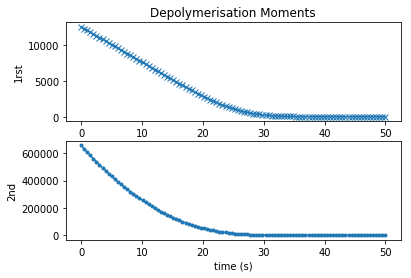

In [9]:
# plotting the 1rst and second moment of depolymerisation
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0,T,NT), mu[0,:], 'x-')
plt.title('Depolymerisation Moments')
plt.ylabel('1rst')

plt.subplot(2, 1, 2)
plt.plot(np.linspace(0,T,NT), mu[1,:], '.-')
plt.xlabel('time (s)')
plt.ylabel('2nd')

plt.show()

## Approche variationnelle

Nous développons l'approche variationnelle dans le cas discret en temps et en espace. Le critère à minimiser s'écrit alors sous forme matricielle :

$\begin{split}
    \mathscr{J}(\zeta,t_{NT}) &= \frac{1}{2}\alpha \parallel \zeta \parallel _{N_{\diamond},\mathscr{Y}}^2 + \frac{1}{2}\gamma \sum_{j=0}^{NT} \delta t \parallel z(t_j) - Ce^{Ft_j}(y_{\diamond}+\zeta) \parallel_{M_j,\mathscr{Z}}^2 \\
	                 &= \frac{1}{2}\alpha \zeta ^T N_{\diamond} \zeta + \frac{1}{2}\gamma \sum_{j=0}^{NT} \delta t (z(t_j) - CG^j(y_{\diamond}+\zeta)^T M_j (z - CG^j(y_{\diamond}+\zeta)\\
					 &=  \frac{1}{2}\alpha \zeta ^T N_{\diamond} \zeta + \frac{1}{2}\gamma \delta t \sum_{j=0}^{NT} (CG^j\zeta)^TM_jCG^j\zeta
			            -2(z(t_j)-CG^jy_{\diamond})^TM_jCG^j\zeta + cste\\
					 &= 1/2 \zeta^T A \zeta - b^T\zeta
\end{split}
$


Cette fonctionnelle se présente sous la forme quadratique usuelle, où les matrices $A$ et $b$ s'exprime en fonction des matrices du problème :

$\begin{cases}
		A = (\alpha N_{\diamond} + \gamma \delta t \sum_{j=0}^{NT} G^{jT}C^TM_jCG^j)\\
		b = \gamma \delta t \sum_{j=0}^{NT} G^{jT} C^T M_j(z(t_j)-CG^jy_{\diamond})
\end{cases}
$

En conclusion, on obtient donc l'équation discrète pour le gradient de la fonctionnelle :

$
\begin{cases}
		\mathrm{d} \mathscr{J}(\zeta,t_{NT})= \alpha N_{\diamond} \zeta + \gamma \delta t \sum_{j=0}^{NT} G^{jT} C^T M_j(z(t_j)-Cy(t_j))\\
		y(t_j) = G^j (y_{\diamond} + \zeta)
\end{cases}
$

On pourrait résoudre ce sysème quadratique directement.
Cependant, implémenter brutalement le calcul des matrices A et notamment b est coûteux en nombre d'opérations, et on préférera résoudre l'équation adjointe. Montrons que l'équation discrete s'écrit sous la forme :

$
\begin{cases}
    q_i^n = G^T q_i^{n+1} + \delta t C^TM_j(z^n-Cy_{|\zeta}^n) \\
    q_i^N_t = 0
\end{cases}
$


On démontre par récurrence :
$
q^0 = q_i^{1} + \frac{b \delta t}{h} (q_{i-1}^{1} - q_i^{1}) + \delta t C^TM_j(z^n-Cy_{|\zeta}^n) 
$

Et en reprenant l'écriture vectorielle adoptée précédemment $q^n = (q_0^n,...,q_{NX}^n)$ :

\[ q^n = G^T q^{n+1} + \delta t C^TM_j(z^n-Cy_{|\zeta}^n) \]

DEMONSTRATION A FINIR : on doit prouver que le q ainsi discrétisé est bien l'adjoint de l'équation discrète.

avec

$
	 G^T =  \left( \begin{array}{cccc}
	 1-CFL  &   0     &  0  & 0 \\
	CFL     & 1-CFL   &  0  & 0 \\
	0      &   CFL     & \ddots &  0 \\
	0      & 0       & CFL    & 1-CFL
	 \end{array} \right).
$


In [10]:
### GRADIENT PARAMETER
iteration_max = 100
gamma = 10000000
alpha = 1
standart_deviation = 1
# Test if the gradient is well computed
test_gradient = False

### 4DVAR #######################################################################################

### INITIALISATION  #############################################################################

# Construction of the norm of the two spaces
norm_observation = (T/NT)*(1/standart_deviation)**2*np.eye(2)
inv_norm_observation = (standart_deviation)**2/(T/NT)*np.eye(2)
norm_state = (L/NX)*np.eye(NX)
inv_norm_state = (NX/L)*np.eye(NX)

# State Initialisation
# Adjoint state 
adjoint_state = np.zeros((NX+1,NT+1))
# State
state_4dvar = np.zeros((NX+1,NT+1)) # current state
# Initial state a priori
state_init = np.zeros((NX+1,iteration_max)) # Initial condition knowing n obervations
#state_init[:-1,0] = gaussienne_d.copy()
# Initial state deviation
state_4dvar[:-1,0] = state_init[:-1,0].copy()
zeta = np.zeros((NX+1,iteration_max))

### PLOTTING SOLUTION  #############################################################################


### PARAMETRE DE RELAXATION #########################################################################
# Calculation of the quadratic matrix A of the function J = 1/2(Azeta,zeta) - (b,zeta)
A_quadratique = alpha*norm_state.copy()
A_inter = gamma*observer_transpose.dot(norm_observation).dot(observer)
A_quadratique += A_inter
for i in range(1,NT+1):
    A_inter = flow_transpose.dot(A_inter).dot(flow)
    A_quadratique += A_inter

# Calculation of the quadratic matrix b of the function J = 1/2(Azeta,zeta) - (b,zeta)
# If test = True then computation of the matrix b 
# in order to compute explicitely differential J
if test_gradient:
    state_apriori = np.zeros((NX,NT+1))
    state_apriori[:,0] = state_init[:-1,0].copy()
    b_linear = gamma*observer_transpose.dot(norm_observation)\
    .dot(mu[:,0]-observer.dot(state_apriori[:,0]))
    for j in range(1,NT+1):
        state_apriori[:,j]=flow.dot(state_apriori[:,j-1])
        b_inter = gamma*observer_transpose.dot(norm_observation)\
        .dot(mu[:,j]-observer.dot(state_apriori[:,j]))
        for k in range(1,j+1):
            b_inter = flow_transpose.dot(b_inter)
        b_linear += b_inter

# Eigenvalue
matrix_eigen = np.linalg.eig(A_quadratique)
eigenvalue_NX = matrix_eigen[0][0]
eigenvalue_0 = matrix_eigen[0][-1]

#Gradient descent parameters
relaxation1 = 2*eigenvalue_0/(eigenvalue_NX**2)
relaxation2 = 2/(eigenvalue_NX+eigenvalue_0)
relaxation = max(relaxation1,relaxation2)
print("le coefficient de relaxation est = {}".format(relaxation))



### GRADIENT DESCENT  ############################################################################

epsilon = np.zeros(iteration_max)
iteration = 0

while (iteration<iteration_max-1):

    # Comnputation of solution knowing the initial condition with k observation
    for i in range(0,NT):
        state_4dvar[:-1,i+1] = np.dot(flow,state_4dvar[:-1,i])
        
    # Computation of the adjoint state
    adjoint_state[:, NT] = np.zeros(NX+1)
    for ii in range(NT,0,-1):
        adjoint_state[:-1,ii-1] = np.dot(flow_transpose, adjoint_state[:-1,ii])\
        + observer_transpose.dot(norm_observation)\
        .dot(mu[:,ii-1]-np.dot(observer,state_4dvar[:-1,ii-1]))
        
    # Incrementing the indicator
    iteration+=1

    # Computation of the gradient
    zeta[:-1,iteration] = zeta[:-1,iteration-1] \
    -relaxation*(alpha*norm_state.dot(zeta[:-1,iteration-1]) - gamma*adjoint_state[:-1,0])

    # Testing : is the gradient correct
    if test_gradient:
        # Precision
        beta = 0.001
        # Diffrential direction
        delta_zeta = beta*np.random.rand(NX+1)
        # Computation by Taylor
        gradJ_diff = np.transpose(np.dot(A_quadratique,zeta[:-1,iteration-1])).dot(delta_zeta[:-1]) \
        -b_linear.dot(delta_zeta[:-1])
        # Computation by adjoint
        grad_adjoint =np.transpose(alpha*norm_state.dot(zeta[:-1,iteration-1]) \
        - gamma*adjoint_state[:-1,0])\
        .dot(delta_zeta[:-1])
        smallo = abs(gradJ_diff - grad_adjoint)
        print(smallo)
        if smallo > beta:
            print("Sorry, the computation of the gradient is false.")
    
    # Computation of epsilon for testing or plotting purpose
    epsilon[iteration-1] = np.transpose(alpha*zeta[:-1,iteration-1]\
    - gamma*inv_norm_state.dot(adjoint_state[:-1,0]))\
    .dot(norm_state)\
    .dot(alpha*zeta[:-1,iteration-1]\
    - gamma*inv_norm_state.dot(adjoint_state[:-1,0]))
 
    # Computation of the initial state
    state_init[:-1,iteration] = state_init[:-1,0] + zeta[:-1,iteration]
    state_init[NX,iteration] = 0
    
    # Re initiatisation of the first step of current state
    state_4dvar[:-1,0] = state_init[:-1,iteration].copy()



le coefficient de relaxation est = 1.1423232293766283e-17


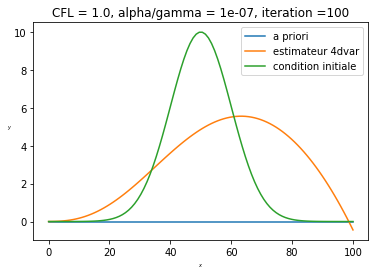

In [11]:
### PLOTTING SOLUTION  #############################################################################

plt.xlabel(u'$x$', fontsize=5)
plt.ylabel(u'$y$', fontsize=5, rotation=0)
plt.title("CFL = {0}, alpha/gamma = {1}, iteration ={2}"\
.format(round(CFL,2),alpha/gamma,iteration_max))
p0 = plt.plot(x, state_init[:-1,0], label= "a priori")
p1 = plt.plot(x, state_init[:-1,iteration_max-1], label= "estimateur 4dvar")
p2 = plt.plot(x, gaussienne, label= "condition initiale")
plt.legend()
plt.show()

La condition initiale est reconstituée globalement via l'algorithme de minimisation.

## Kalman Filter

#### Equation de Riccati en temps discret

La méthode variationnelle décrite plus haut présente un inconvénient : la convergence pour obtenir l'optimum $\zeta$ peut exiger un nombre important d'itération (plus de $10^3$) puisque l'optimum est calculé globalement.
De plus nécessite de bien caler le paramètre de relaxation (soit de le calculer ce qui exige des itérations supplémentaires pour le calcul des matrices $A$ et $b$).
Nous proposons de procéder par le filtre de Kalmen, équivalente à la méthode variationnelle pour le cas linéaire de l'équation de transport, mais dont la convergence est progressive, au fur et à mesure que les observations sont introduites dans l'équation. 

 Revenons à l'équation discrète de $\mathscr{J}$ . On note $\bar{\zeta} = \zeta_{|n}$ le vecteur pour lequel le minimum de $\mathscr{J}$ est atteint pour $n$ observations. 

$
	\begin{cases}
		\displaystyle A_n = (\alpha N_{\diamond} + \gamma \delta t \sum_{j=0}^{n} G^{jT}C^TM_jCG^j)\\
		b_n = \gamma \delta t \sum_{j=0}^{n} G^{jT} C^T M_j(z(t_j)-CG^jy_{\diamond}) \\
		\zeta_{|n} = argmin \mathscr{J}(n) \\
		A_n \zeta_{|n} = b_n
	\end{cases}
$

$A_n$ est coercive donc inversible donc $\zeta_{|n} = A_n^{-1}b_n$. A partir de cette égalité, on va construire par récurrence $\zeta_{|n}$ en fonction de $\zeta_{|n-1}$, puis la solution $y_{n|n}=G^ny_{0|n}= G^n(y_{\diamond}+ \zeta_{|n})$.

$
	\zeta_{|n} = (\alpha N_{\diamond} + \gamma \delta t \sum_{j=0}^{n} G^{jT}C^TM_jCG^j)^{-1}(\gamma \delta t \sum_{j=0}^{n} G^{jT} C^T M_j(z(t_j)-CG^jy_{\diamond}) )
$

Soit la matrice de norme $\tilde{M}_n= \gamma \delta t M_n$, et la résolvante discrète $\Psi_n = CG^n$ :

$
	\begin{split}
	A_n &= \alpha N_{\diamond} + \gamma \delta t \sum_{j=0}^{n} G^{jT}C^TM_jCG^j \\
	       &= A_{n-1} + \gamma \delta t G^{nT}C^TM_nCG^n\\
		  &= A_{n-1} + \Psi_n^T\tilde{M}_n\Psi_n
    \end{split}
$

En utilisant le lemme d'inversion matricielle :

$
A_n^{-1} = A_{n-1}^{-1} - A_{n-1}^{-1}\Psi_n^T(\tilde(M)_n^-1 + \Psi_n A_{n-1}^-1 \Psi_n^T)^-1\Psi_n A_{n-1}^-1
$

Et en réécrivant l'égalité :
$
  A_{n-1}^{-1} b_{n-1} = A_{n-1}^{-1} (\sum_{j=0}^{n-1} \Psi_j^T\tilde{ M_j}(z(t_j)-CG^jy_{\diamond}) = \zeta_{|n-1})
$

On trouve une expression de récurrence pour $\zeta_{|n}$ :

$
	\begin{split}
	\zeta_{|n} &= \zeta_{|n-1} + A_{n-1}^{-1}\Psi_n^T(\tilde(M)_n^{-1} + \Psi_n A_{n-1}^{-1} \Psi_n^T)^-1(z(t_n)-\Psi_n (y_{\diamond} + \zeta_{|n-1})) \\
	           &= \zeta_{|n-1} + A_{n}^{-1} \Psi_n^T \tilde{M}_n (z(t_n)-\Psi_n y_{0|n-1}) 
	\end{split}
$

On note $y_{0|n-1}$ la condition initiale sachant $n-1$ observations, et $y_{0|n-1} = y_{\diamond} + \zeta_{|n-1}$. Enfin, pour s'affranchir du calcul de $G^n$ dans cette formule, on trouve une expression de récurrence pour 
$y_{n|n} = G^n (y_{\diamond} + \zeta_{|n})$ :

$
\begin{split}
y_{n|n} &= G^n (y_{\diamond} + \zeta_{|n}) \\
        &= G^n (y_{\diamond} + \zeta_{|n-1}) + G^n A_{n}^-1\Psi^T \tilde{M}_n (z(t_n)-\Psi_n y_{0|n-1}) \\
		&= G y_{n-1|n-1} + (G^nA_{n}^{-1} G^{nT}) C^T \tilde{M}_n (z(t_n)-CG( G^{n-1} y_{0|n-1})) \\
		&= G y_{n-1|n-1} + P_n C^T \tilde{M}_n (z(t_n)-CGy_{n-1|n-1})		
\end{split}
$

Avec l'opérateur de covariance $P_n = G^nA_{n}^{-1} G^{nT}$.

De part cette expression on peut reconstruire en deux étapes la dynamique de l'estimateur de Kalman discret $\hat{y}$ : 

$\begin{cases}
		\text{Initialisation :}\\
		P_0^- = P_{\diamond} = \mathbb{1} \\
		y_0^- = y_{\diamond} \\
		\text{Correction :}\\
		K_n = P_n^- C^T (\tilde(M)_n^{-1} + C^TP_n^-C)^-1 \\
		P_n^+ = (\mathbb{I} - K_nC)P_n^-(\mathbb{I}-K_nC)^T + K_n \tilde{M}_n^{-1} K_n^T\\
		y_n^+ = y_n^- + P_n^+C^T \tilde{M}_n ( z_n - Cy_n^-)\\
		\text{Prediction :}\\
		P_{n+1}^- = G P_n^+ G^T
		y_{n+1}^- = G y_n^+
	\end{cases}$


#### Reconstitution de la condition initiale

La construction de l'estimateur de Kalman ci-dessus nous permet de reconstituer la solution au temps $t_n = n \delta t$. 

Afin de retrouver directement la condition initiale à l'instar de la méthode variationnelle, il nous suffit d'introduire dans l'estimateur de Kalman obtenu ci-dessus le paramètre $y_0$. La dynamique $G$ devient :

$
\begin{cases}
		y_{n+1} = G y_n \\
		y_{0,n+1} = \mathbb{I} y_{0,n}
\end{cases}
$

On est ramené au cas précédent.

In [13]:
## KALMAN FILTER #################################################################################

### INITIALISATION
# Construction of the observer (equal zero for the initial condition taken as parameter)
observer_kalman = np.vstack((operator_moment_1, np.zeros(NX), \
operator_moment_2, np.zeros(NX)))\
.reshape(2,2*(NX))

# Construction of the new dynamic (identity for the initial condition)
flow_kalman = np.concatenate((\
np.concatenate((flow,np.zeros((NX,NX))),axis=1),\
np.concatenate((np.zeros((NX,NX)),np.eye(NX)),axis=1)))

# Construction of the norm of the two spaces
standart_deviation = 0.00001
norm_observation = (T/NT)*(1/standart_deviation)**2*np.eye(2)
inv_norm_observation = (NT/T)*(standart_deviation)**2*np.eye(2)
#norm_state = (L/NX)*np.eye(NX)

# Initialisation of the covariance matrix
covariance_operator_m = np.kron(np.ones((2,2)),np.eye(NX))
covariance_operator_p = covariance_operator_m.copy()

# Initialisation of the state
state_init = 10*np.exp(-(x-L/3)**2/(2*sigma**2))
state_init[NX-1]=0
state_m = np.kron(np.ones(2),state_init)
state_p = state_m.copy()
state_kalman = np.zeros((2*NX,NT))

### KALMAN FILTER
for k in range(0,NT):
    # Saving the solution
    state_kalman[:,k] = state_m.copy()

    ### CORRECTION
    # Covariance computation +
    interim_matrix = inv_norm_observation + observer_kalman.dot(covariance_operator_m).dot(observer_kalman.transpose())
    kalman_gain = covariance_operator_m.dot(observer_kalman.transpose()).dot(np.linalg.inv(interim_matrix))

    covariance_operator_p = (np.eye(2*NX) - kalman_gain.dot(observer_kalman)).dot(covariance_operator_m)\
    .dot(np.transpose((np.eye(2*NX) - kalman_gain.dot(observer_kalman)))) \
    + kalman_gain.dot(inv_norm_observation).dot(np.transpose(kalman_gain))

    # State correction computation +
    state_p = state_m + kalman_gain\
    .dot(mu[:,k]- np.dot(observer_kalman,state_m))

    ### PREDICTION
    # Covariance computation -
    covariance_operator_m = flow_kalman.dot(covariance_operator_p).dot(flow_kalman.transpose())

    # State prediction computation -
    state_m = np.dot(flow_kalman,state_p)

In [42]:
### PLOTTING KALMAN
# Set up the figure, the axis, and the plot element we want to animate
kalmanfilter = PlotDymamicSolution(L,1.1*np.amax(state_kalman[NX:,:]),\
                                   np.linspace(0, L, NX),state_kalman[NX:,:],\
                                   NT,'time = %.1f',np.linspace(0,T,NT))
kalmanfilter

La condition inititale est reconstruite au fur et à mesure que les valeurs des observations sont introduites dans l'équation.

## Kalman with noises

In [50]:
### PLOTTING NOISE GROWING ON OBSERVATIONS
# Generate noise
noise_level = (T/NT)*1/2*np.sqrt(np.linalg.norm(mu[0,:]))
noise = np.linspace(0,20,20).reshape(20,1)
ones  = np.ones(20).reshape(20,1)
munoise = np.kron(noise,noise_level*np.random.rand(NT)) \
         + np.kron(ones,mu[0,:])
munoise = munoise.transpose()


# Set up the figure, the axis, and the plot element we want to animate
datanoise1 = PlotDymamicSolution(T,1.1*np.amax(mu[0,:]),\
                                   np.linspace(0, T, NT),munoise,\
                                  20,'noise = %.3f',np.linspace(0,0.2,20))
datanoise1

